# Hazard Assessment for Wildfire - Machine Learning Approach (ECLIPS dataset)

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FIRE](https://github.com/CLIMAAX/FIRE) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

## Introduction

This Jupyter Notebook is used to compute a Hazard map for an area of interest using these inputs: DEM, Corine land-cover, Fire data, administrative level (NUTS).
Moreover, it is used to analyze fire hazard data and perform various preprocessing and analysis tasks.

The analysis is based on the hazard mapping works of [Tonini et al. 2020](https://doi.org/10.3390/geosciences10030105), [Trucchia et al. 2023](https://doi.org/10.1071/WF22138).

The workflow is based on the following steps:

- Data gathering and preprocessing.
- Building a model for wildfire susceptibility using present climate conditions and synoptic wildfire events. 
- Projecting the model to future climate conditions. 
- For both cases, susceptibility can be evolved to hazard by considering the different plant functional types, which are a proxy for the intensity of potential wildfires. See [Trucchia et al. 2023](https://doi.org/10.1071/WF22138) for more details. 
- Damage assessment for different vulnerability categories and exposed elements (roads) in order to get Risk maps.

Regarding climate, the analysis revolves around a high-resolution gridded climate dataset for Europe based on bias-corrected EURO-CORDEX: the ECLIPS-2.0 dataset. ECLIPS (European CLimate Index ProjectionS) dataset contains gridded data for 80 annual, seasonal, and monthly climate variables for two past (1961-1990, 1991-2010) and five future periods (2011-2020, 2021-2140, 2041-2060, 2061-2080, 2081-2100). The future data are based on five Regional Climate Models (RCMs) driven by two greenhouse gas concentration scenarios, RCP 4.5 and 8.5. See [Debojyoti et al. 2020](https://doi.org/10.5281/zenodo.3952159) for more details.


:::{seealso}

We also provide a version of this hazard assessment notebook based on the CHELSA dataset: [Hazard assessment for Wildfire - CHELSA dataset](Hazard_assessment_FIRE_ML_CHELSA.ipynb).
:::

## Preparation Work

The notebook is configured for the **Catalonia** region in Spain as a case study.
A prepared [sample dataset](https://handbook.climaax.eu/resources/datasets/wildfire_sample_cat.html) for Catalonia is available from the CLIMAAX cloud storage.

:::{admonition} Assessing risk for other regions
:class: important

To assess the wildfire hazard and risk for a **different region**, data equivalent to the provided Catalonia sample have to be provided and substituted throughout the workflow.
This includes:

- A shapefile of the region (sample data in `data_*/boundaries`)
- Digital Elevation Model (DEM) raster data (sample data for Spain in `data_*/dem2_3035.tif`)
- Land cover data (sample data from [CORINE](https://land.copernicus.eu/en/products/corine-land-cover) in `data/veg_corine_reclass.tif`)
- A dataset of historical fires (sample data in `data_*/fires`)
- A climate dataset with parameters relating to fuel availability and fire danger (workflow based on [ECLIPS-2.0](https://doi.org/10.5281/zenodo.3952159); resized sample data in `data_*/climate`).
- Vulnerability data (sample data from [JRC](https://doi.org/10.2760/46951) with European coverage in `/data/vulnerability`; *risk assessment only*)
- Exposure data, e.g. for critical infrastructure (sample data in `data_*/exposure/`; *risk assessment only*)
- NUTS level data for aggregation (sample data for Spain in `data/administrative_units_NUTS/`; *risk assessment only*)

To simplify the creation of the climate dataset for input in the machine learning model, CLIMAAX provides a (partial) [dataset mirror](https://handbook.climaax.eu/resources/datasets/eclips2.0_mirror.html) of relevant parameters from the ECLIPS-2.0 dataset.
For the purposes of this workflow, we recommend downloading the ECLIPS-2.0 data via this mirror, as the original dataset is only provided as a single 87.2 GB-large compressed archive file.
See below for options for obtaining the climate dataset.
:::

Most of the analysis is based on raster calculations. The "base" raster is a clipped dem file (path in variable `dem_path_clip` below), which has been clipped using the extent of the Catalonia administrative shapefile. The raster is metric, using the EPSG:3035 projection, with 100 meter resolution, and with extent (left, bottom, right, top) given by:

    3488731.355 1986586.650 3769731.355 2241986.650

### Import libraries

:::{admonition} Find more info about the libraries used in this workflow here
:class: hint dropdown

- [pathlib](https://docs.python.org/3/library/pathlib.html): File path manipulation and file system access.
- [os](https://docs.python.org/3/library/os.html): Provides functions for interacting with the operating system, such as file operations and environment variables.
- [pooch](https://www.fatiando.org/pooch/latest/index.html): To download data from various sources (Zenodo, CLIMAAX cloud storage)
- [rasterio](https://rasterio.readthedocs.io/en/stable/): A library for reading and writing geospatial raster datasets. It provides functionalities to work with raster data formats such as GeoTIFF and perform various raster operations.
- [tqdm](https://github.com/tqdm/tqdm): A fast, extensible progress bar for Python and CLI. It allows for easy visualization of loop progress and estimates remaining time.
- [matplotlib.pyplot](https://matplotlib.org/): Matplotlib's plotting interface, providing functions for creating and customizing plots. %matplotlib inline is an IPython magic command to display Matplotlib plots inline within the Jupyter Notebook or IPython console.
- [numpy](https://numpy.org/): A fundamental package for scientific computing with Python. It provides support for large multi-dimensional arrays and matrices, along with a collection of mathematical functions to operate on these arrays.
- [gdal](https://gdal.org/) (in `shared_funcs`): Python bindings for the Geospatial Data Abstraction Library (GDAL), used for reading and writing various raster geospatial data formats.
- [geopandas](https://geopandas.org/): Extends the Pandas library to support geometric operations on GeoDataFrames, allowing for easy manipulation and analysis of geospatial data.
- [pandas](https://pandas.pydata.org/): A powerful data manipulation and analysis library for Python. It provides data structures like DataFrame for tabular data and tools for reading and writing data from various file formats.
- [scipy.signal](https://docs.scipy.org/doc/scipy/reference/signal.html) (in `shared_funcs`): Provides signal processing tools, including functions for filtering, spectral analysis, and convolution.
- [sklearn](https://scikit-learn.org/stable/) (in `shared_funcs`): The scikit-learn library for machine learning in Python. It includes various algorithms for classification, regression, clustering, dimensionality reduction, and more. train_test_split is a function for splitting datasets into train and test sets, and RandomForestClassifier is an implementation of the Random Forest classifier algorithm.
:::

In [1]:
import os
import pathlib

import pooch
from tqdm import tqdm

import numpy as np
import geopandas as gpd
import pandas as pd
import rasterio
import rasterio.plot
from rasterio.mask import mask

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

Import workflow-specific functions shared between the ECLIPS and CHELSA notebooks from the [`shared_funcs.py`](shared_funcs.py) file:

In [2]:
import shared_funcs

### Area name

Name for the area of interest (used for regional data folder and plot titles):

In [3]:
areaname = "Catalonia"

### Path configuration

Paths to data for the layers used in the notebook (mostly rasters and shapefiles).

In [4]:
# Folder for general input files
data_path = pathlib.Path("./data")

# Digital elevation model
dem_path_full = data_path / "dem2_3035.tif"  # input
# Land cover
clc_path_full = data_path / "veg_corine_reclass.tif"  # input

# ECLIPS-2.0 dataset folder (see below)
ECLIPS2p0_path = pathlib.Path("./ECLIPS2.0/")

Region-specific files (input and output) are separated from the general input files:

In [5]:
# Folder for regional input and output files
data_path_area = pathlib.Path(f"./data_{areaname}")

# Digital Elevation Model
dem_path = data_path_area / "dem"
dem_path.mkdir(parents=True, exist_ok=True)
dem_path_clip = dem_path / "dem_clip.tif"  # output
dem_path_slope = dem_path / "slope.tif"  # output
dem_path_aspect = dem_path / "aspect.tif"  # output
dem_path_easting = dem_path / "easting.tif"  # output
dem_path_northing = dem_path / "northing.tif"  # output
dem_path_roughness = dem_path / "roughness.tif"  # output

# Land cover/use dataset
clc_path = data_path_area / "land_cover"
clc_path.mkdir(parents=True, exist_ok=True)
clc_path_clip = clc_path / "veg_corine_reclass_clip.tif"  # output
clc_path_clip_nb = clc_path / "veg_corine_reclass_clip_nb.tif"  # output, non-burnable

# Fires
fires_path = data_path_area / "fires"
fires_path.mkdir(parents=True, exist_ok=True)
fires_path_shapes = fires_path / "Forest_Fire_1986_2022_filtrat_3035.shp"  # input
fires_path_raster = fires_path / "fires_raster.tif"  # output

# Shapefile for area of interest
bounds_path = data_path_area / "boundaries"
bounds_path_area = bounds_path / f"{areaname}_adm_3035.shp"  # input

# Folder for resized ECLIPS-2.0 data
clim_path = data_path_area / "climate"  # output
clim_path.mkdir(parents=True, exist_ok=True)

# Output folder for hazard rasters
suscep_path = data_path_area / "susceptibility"
suscep_path.mkdir(parents=True, exist_ok=True)

# Output folder for hazard rasters
hazard_path = data_path_area / "hazard"
hazard_path.mkdir(parents=True, exist_ok=True)

### Download Catalonia sample data

To run the workflow for the Catalonia region, a [sample input dataset](https://handbook.climaax.eu/resources/datasets/wildfire_sample_cat.html) is downloaded from the CLIMAAX cloud storage.
We will download all files here before continuing.
A registry for the data that can be used by the pooch package is included with the workflow repository (`files_registry.txt`).
We load it here and retrieve all listed files.
If any files were downloaded before, pooch will inspect the local file contents and skip the download if the contents match expectations.

The data is downloaded into the folder `./data_Catalonia` (see variable `areaname`).

In [6]:
# Make sure that path configuration is appropriate for the example dataset
assert areaname == "Catalonia"

# Pooch downloader for workflow directory and CLIMAAX cloud storage
sample_pooch = pooch.create(
    path=".",
    base_url="https://object-store.os-api.cci1.ecmwf.int/climaax/wildfire_sample_cat/"
)
sample_pooch.load_registry("files_registry_cat.txt")

# Download all files from the attached registry
for path in sample_pooch.registry:
    if not path.startswith(str(clim_path)):
        sample_pooch.fetch(path)

## Region shapefile

Load a provided shapefile for the region of interest for clipping and plotting.

In [7]:
region_borders = gpd.read_file(bounds_path_area)

## Reference DEM

We use a Digital Elevation Model (DEM) of the area of interest as a reference for clipping other rasters.
The reference DEM is read as as a GeoTIFF with CRS[EPSG:3035].
The resolution of the DEM from the Catalonia example dataset is 100m.

### Clipping (if necessary)

The next cell can be used to extract the reference DEM from a larger DEM (`dem_path_full`) based on the provided shapefile of the area of interest (`bounds_path_area`).
If you are providing a reference DEM is directly (`dem_path_clip`), skip the next code cell.

In [8]:
# Clip raster with shapefile of area of interest
shapes = region_borders.geometry.values

# Clip the DEM file
with rasterio.open(dem_path_full) as src:
    out_image, out_transform = mask(src, shapes, crop=True)
    out_meta = src.meta.copy()

out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save the clipped raster
with rasterio.open(dem_path_clip, "w", **out_meta) as dest:
    dest.write(out_image)

Load the clipped DEM file as a reference for masking other raster data:

In [9]:
with rasterio.open(dem_path_clip) as src:
    ref = src.read(1)
    # Boundaries
    left = src.bounds.left
    bottom = src.bounds.bottom
    right = src.bounds.right
    top = src.bounds.top
    print(src.bounds)

### Obtain the slope and aspect layers

Process DEM: calculate slope, aspect and roughness and save them into the output folder.

Reading dem file data_Catalonia/dem/dem_clip.tif
This is what data_Catalonia/dem/dem_clip.tif looks like


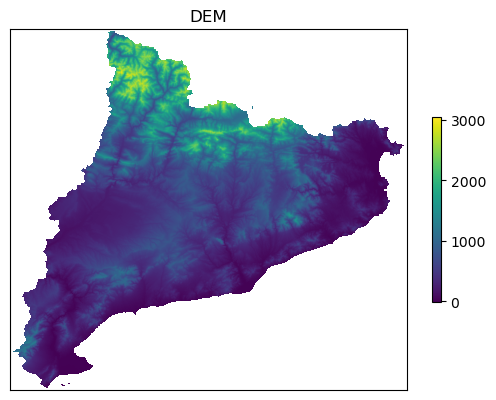

Calculating slope, aspect and roughness


Calculating northing and easting files
Reading aspect file data_Catalonia/dem/aspect.tif
Aspect looks like this...


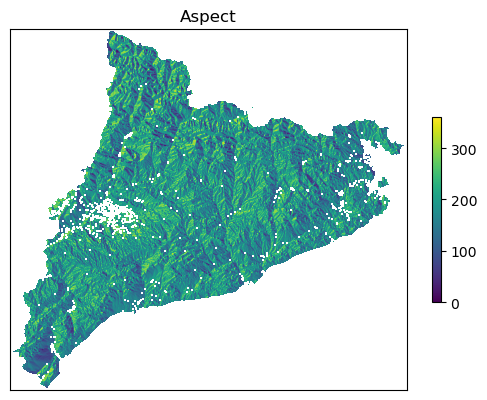

Saving northing file data_Catalonia/dem/northing.tif
Saving easting file data_Catalonia/dem/easting.tif


In [11]:
shared_funcs.process_dem(dem_path_clip, dem_path, verbose=True)

## ECLIPS-2.0 climate dataset

To overlay wildfire polygons with climate data, and to perform future projections of wildfire hazard, a climate dataset is needed.
Here, we make use of the [ECLIPS-2.0](https://doi.org/10.5281/zenodo.3952159) dataset based on bias-corrected EURO-CORDEX (Chakraborty et al., 2020).

### Data variables

:::{dropdown} Variable table

| Acronym             | Variable name                       | Unit  |
|---------------------|-------------------------------------|-------|
| MWMT                | Mean warmest month temperature      | °C    |
| MCMT                | Mean coldest month temperature      | °C    |
| TD                  | Continentality                      | °C    |
| AHM                 | Annual heat:moisture index          | °C/mm |
| SHM                 | Summer heat:moisture index          | °C/mm |
| DDbelow0            | Degree-days below 0°C               | °C    |
| DDabove5            | Degree-days above 5°C               | °C    |
| DDbelow18           | Degree-days below 18°C              | °C    |
| DDabove18           | Degree-days above 18°C              | °C    |
| NFFD                | Number of frost-free days           | -     |
| FFP                 | Longest frost-free period           | days  |
| bFFP                | Begining of FFP                     | day   |
| eFFP                | End of FFP                          | day   |
| EMT                 | Extreme minimum temperature         | °C    |
| MAT                 | Annual mean temperaure              | °C    |
| MAP                 | Annual total precipitation          | mm    |
| Tmin_an             | Annual mean of minimum temperature  | °C    |
| Tmax_an             | Annual mean  of maximum temperature | °C    |
| Tmax_01 to Tmax_12  | Maximum monthly temperatures        | °C    |
| Tmin_01 to Tmin_12  | Minimum monthly temperatures        | °C    |
| Tave_01 to Tave_12  | Mean monthly temperatures           | °C    |
| Tave_at             | Mean autumn temperature             | °C    |
| Tave_sm             | Mean summer temperature             | °C    |
| Tave_sp             | Mean spring temperature             | °C    |
| Tave_wt             | Mean winter temperature             | °C    |
| Tmax_at             | Maximum autumn temperature          | °C    |
| Tmax_sm             | Maximum summer temperature          | °C    |
| Tmax_sp             | Maximum spring temperature          | °C    |
| Tmax_wt             | Maximum winter temperature          | °C    |
| Tmin_at             | Minimum autumn temperature          | °C    |
| Tmin_sm             | Minimum summer temperature          | °C    |
| Tmin_sp             | Minimum spring temperature          | °C    |
| Tmin_wt             | Minimum winter temperature          | °C    |
| PPT_at              | Mean autumn precipitation           | mm    |
| PPT_sm              | Mean summer precipitation           | mm    |
| PPT_sp              | Mean spring precipitation           | mm    |
| PPT_wt              | Mean winter precipitation           | mm    |
| PPT_01 to PPT_12    | Mean monthly precipitation          | mm    |

:::

The data is structured like this:

| Feature                 | Description  |
|----------------------------|------------|
| Resolution                 | 30 arcsec  |
| Coordinate System          | WGS 84     |
| Projection                 | CRS ("+proj=longlat +datum=WGS84"),  (EPSG:4326)|
| Data Format                | GeoTIFF|
| Extent                     | -32.65000, 69.44167, 30.87892, 71.57893  (xmin, xmax, ymin, ymax) |
| Temporal scale             |  Past climate: mean of 1961-1990 & 1991-2010 |
|                            | Future periods: Means of 2011-2020, 2021-2040,  2041-2060, 2061-2080,2081-2100 |
| Climate forcing scenarios  | RCP 8.5 and RCP 4.5 |
| Number of variables | 80 |

We want the following set of variables:

- MWMT, Mean warmest month temperature
- TD, Continentality
- AHM, Annual Heat-Moisture Index
- SHM, Summer Heat-Moisture Index
- DDbelow0, Degree-days below 0°C
- DDabove18, Degree-days above 18°C
- MAT, Annual mean temperaure
- MAP, Annual total precipitation
- Tave_sm, Mean summer temperature
- Tmax_sm, Maximum summer temperature
- PPT_at, Mean autumn precipitation
- PPT_sm, Mean summer precipitation
- PPt_sp, Mean spring precipitation
- PPT_wt, Mean winter precipitation

With these descriptors we can catch some features related to fuel availability and fire danger:

- MWMT, TD, DDbelow0, DDabove18, MAT, Tave_sm, Tmax_sm are related to temperature, with a particular focus on the summer season.
- AHM, SHM, are related to the interplay between heat and moisture, also with a focus on summer period.
- MAP, PPT_at, PPT_sm, PPt_sp, PPT_wt are related to precipitation, with a particular focus on the seasonality.

In [12]:
var_names = [
    "MWMT", "TD", "AHM", "SHM", "DDbelow0", "DDabove18", "MAT",
    "MAP", "Tave_sm", "Tmax_sm", "PPT_at", "PPT_sm", "PPT_sp", "PPT_wt"
]

### Select historical period for model training

First, we download historical data for the model training.
ECLIPS-2.0 offers historical data for two periods:

- `196190`: 1961 to 1990
- `199110`: 1991 to 2010

Select your period (should cover fires database loaded later for model training):

In [13]:
hist_period = "199110"

In [14]:
# Account for a typo in the 199110 folder name
hist_folder = ("ECLPS2.0_" if hist_period == "199110" else "ECLIPS2.0_") + hist_period

# Create an id from the config to use in filenames
hist_config_id = f"HIST_{hist_period}"

# Input files historical climate from ECLIPS2.0 dataset
eclips_files_hist = [ECLIPS2p0_path / hist_folder / f"{vv}_{hist_period}.tif" for vv in var_names]

Three options to proceed with the ECLIPS-2.0 climate dataset:

### Option A: download data from the CLIMAAX cloud storage

The required input files for the machine learning wildfire hazard model can be downloaded from our [dataset mirror](https://handbook.climaax.eu/resources/datasets/eclips2.0_mirror.html) on the CLIMAAX cloud storage.

In [15]:
eclips_mirror_pooch = pooch.create(
    path=ECLIPS2p0_path,
    base_url="https://object-store.os-api.cci1.ecmwf.int/climaax/eclips2.0_mirror/"
)
eclips_mirror_pooch.load_registry("files_registry_eclips.txt")

In [16]:
for file in eclips_files_hist:
    file_rel = file.relative_to(eclips_mirror_pooch.path)
    eclips_mirror_pooch.fetch(str(file_rel))

### Option B: use resized data from Catalonia sample dataset

A limited set of already resized climate data based on the ECLIPS-2.0 dataset are provided with the Catalonia sample dataset introduced above.
These files can be used for testing, but cover only a small range of configurations for the future climate.

When using the resized sample data, the resizing steps in the following can be skipped.

In [ ]:
for path in sample_pooch.registry:
    if path.startswith(str(clim_path)):
        sample_pooch.fetch(path)

### Option C: download the full dataset from Zenodo

:::{attention}
The data is provided as a single 87.2 GB-large compressed [7z archive](https://www.7-zip.org/7z.html) file.
This file has to be unpacked after downloading, requiring at least another 90 GB of free disk space and a 7z-capable unpacking application.
If you do not require additional fields from the ECLIPS2.0 dataset, we strongly recommend using our dataset mirror instead (Option A).
:::

Execute the next two cells to download, verify and unpack the `ECLIPS2.0.7z` file.
This can take a while.
Here, we use the command line application `7za` that can be installed on Mac and Linux computers with the [p7zip](https://anaconda.org/conda-forge/p7zip) package from conda-forge in the `climaax_fire` to unpack the contents.
For Windows computers, the [7zip](https://www.7-zip.org) application is available.

In [ ]:
pooch.retrieve(
    "doi:10.5281/zenodo.3952159/ECLIPS2.0.7z",
    path=".",
    fname="ECLIPS2.0.7z",
    known_hash="e70aee55e365f734b2487c7b8b90f02fc57f6ff80f23f3980d1576293fbadea6",
    progressbar=True
)

In [ ]:
! 7za x "ECLIPS2.0.7z"

### Resizing of the climate rasters

In [17]:
# Output folder for resized historical climate raster files
clim_path_hist = clim_path / hist_config_id

In [18]:
def resize_rasters_gdalwarp(raster_list, output_subfolder):
    # Create the output subfolder if it doesn't exist
    os.makedirs(output_subfolder, exist_ok=True)
    # Return list of output file paths
    output_paths = []
    # Loop through the list and perform gdalwarp for each raster
    for raster_path in tqdm(raster_list):
        # Get the filename from the path
        filename = os.path.basename(raster_path)
        # Construct the output path by joining the output folder, the subfolder and the filename
        output_path = os.path.join(output_subfolder, filename)
        output_paths.append(output_path)
        # Perform gdalwarp using the string command. I use the data of the blueprint DEM raster as a reference
        os.system(f"gdalwarp -t_srs EPSG:3035 -tr 100 -100 -te {left} {bottom} {right} {top} -r bilinear  -overwrite -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=YES -co BLOCKXSIZE=512 -co BLOCKYSIZE=512 {raster_path} {output_path}")
    return output_paths


def check_resized_rasters(raster_list, reference_raster_path):
    for output_raster_path in tqdm(raster_list):
        raster_path = os.path.basename(output_raster_path)
        with rasterio.open(output_raster_path) as output_raster:
            # Open the reference raster
            with rasterio.open(reference_raster_path) as reference_raster:
                # Get the dimensions of the output raster
                output_rows, output_cols = output_raster.shape
                # Get the dimensions of the reference raster
                reference_rows, reference_cols = reference_raster.shape
                # Compare the dimensions
                if output_rows == reference_rows and output_cols == reference_cols:
                    print(f"{raster_path} has the same dimensions as the reference raster.")
                else:
                    print(f"{raster_path} does NOT have the same dimensions as the reference raster.")

Resize the rasters and check if the dimensions of the output rasters are the same as the reference raster (not necessary when using the Catalonia sample data):

In [19]:
clim_files_hist = resize_rasters_gdalwarp(eclips_files_hist, clim_path_hist)
check_resized_rasters(clim_files_hist, dem_path_clip)

100%|██████████| 14/14 [00:00<00:00, 241.92it/s]

## Landcover (land use raster)

### Resizing

Clip the CORINE raster to the extent of the area of interest and reproject to `EPSG:3035`:

In [20]:
os.system(f"gdalwarp -t_srs EPSG:3035 -tr 100 -100 -te {left} {bottom} {right} {top} -r near  -overwrite -co COMPRESS=LZW -co TILED=YES -co BIGTIFF=YES -co BLOCKXSIZE=512 -co BLOCKYSIZE=512 {clc_path_full} {clc_path_clip}")

Creating output file that is 2810P x 2554L.
Using internal nodata values (e.g. 0) for image data/veg_corine_reclass.tif.
Copying nodata values from source data/veg_corine_reclass.tif to destination data_Catalonia/land_cover/veg_corine_reclass_clip.tif.
Processing data/veg_corine_reclass.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


0

### Preprocessing

The shape(rows-columns) of LC map is:  (2554, 2810) 
 Datatype is:  int16 
 The range of values are:  0 523
Values of LC codes are:  
 [  0 111 112 121 122 123 124 131 132 133 141 142 211 212 213 221 222 223
 231 241 242 243 311 312 313 321 322 323 324 331 332 333 334 335 411 421
 422 511 512 521 523]


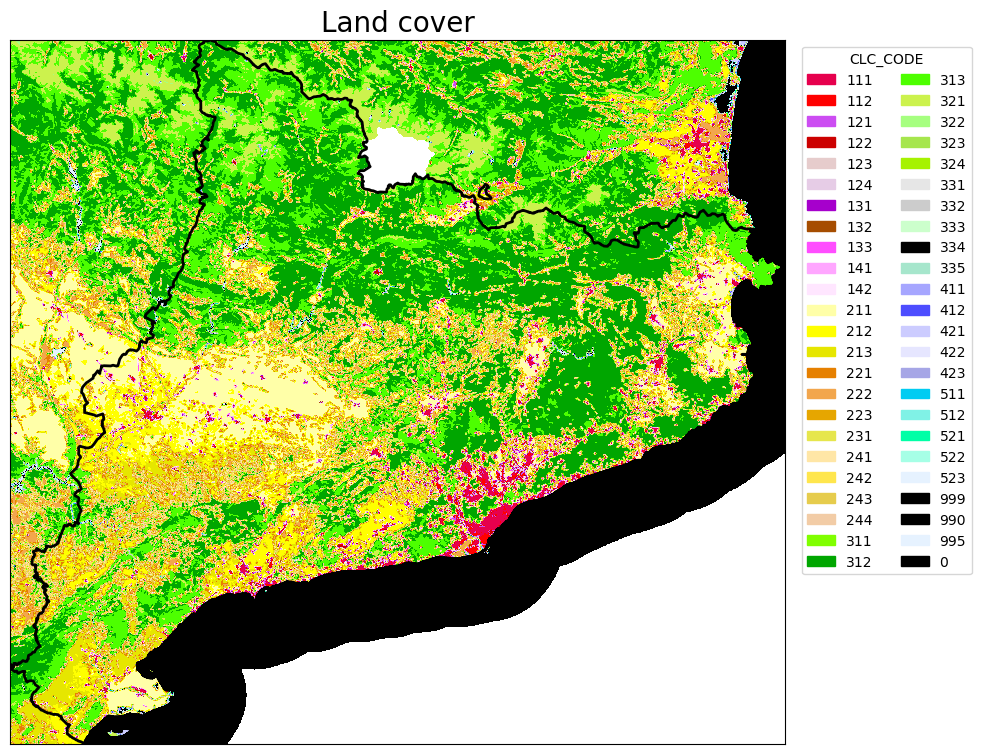

In [21]:
# Create an info dataframe on CLC land cover
clc_leg = pd.read_excel("clc2000legend.xls")

# Eliminate nans of the dataframe in column CLC_CODE, wioll put "0-0-0"
clc_leg["RGB"] = clc_leg["RGB"].fillna("0-0-0")

# Create dataframe with CLC_CODE, R, G, B (using split of RGB of clc_leg)
clc_leg["R"] = clc_leg["RGB"].apply(lambda x: int(x.split("-")[0]))
clc_leg["G"] = clc_leg["RGB"].apply(lambda x: int(x.split("-")[1]))
clc_leg["B"] = clc_leg["RGB"].apply(lambda x: int(x.split("-")[2]))

# I need to create a row for accouting for 0 values in the raster
_zero_values_row = pd.DataFrame({"CLC_CODE": 0, "LABEL3": "No data/Not Burnable", "R": 0, "G": 0, "B": 0}, index=[0])
clc_leg = pd.concat([clc_leg, _zero_values_row]).reset_index(drop=True)

# Create a colormap from the DataFrame
# For all clc codes
cmap = mcolors.ListedColormap(clc_leg[['R', 'G', 'B']].values/255.0, N=clc_leg['CLC_CODE'].nunique())
# For all clc codes except not burnable codes
cmap2 = mcolors.ListedColormap(clc_leg[['R', 'G', 'B']].values/255.0, N=clc_leg['CLC_CODE'].nunique() - 1)

# Create a list to hold the legend elements
legend_elements = []
# Iterate over the rows of the DataFrame
for _, row in clc_leg.iterrows():
    # Create a patch for each CLC code with the corresponding color and label
    color = (row['R']/255.0, row['G']/255.0, row['B']/255.0)
    #print(color)
    label = str(row['CLC_CODE'])
    #print(label)
    patch = mpatches.Patch(color=color, label=label)
    #print(patch)
    # Add the patch to the legend elements list
    legend_elements.append(patch)

# PLOT THE LAND COVER RASTER

# Open the raster data
with rasterio.open(clc_path_clip) as src:
    # Read the raster band
    band = src.read(1)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Plot the raster
    rasterio.plot.show(src, ax=ax, cmap = cmap)
    # Plot the shapefile
    region_borders.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=2)
    # band is the raster data.  I want to know nrows, ncols, NODATA_value, dtype.
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.25, 1), title="CLC_CODE", ncols=2)
    ax.set_title("Land cover", fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    print('The shape(rows-columns) of LC map is: ', band.shape,'\n','Datatype is: ', band.dtype,'\n', 'The range of values are: ' , band.min(),band.max())
    print('Values of LC codes are: ', '\n', np.unique(band))

Save the raster of clc with all non-burnable classes set to 0:

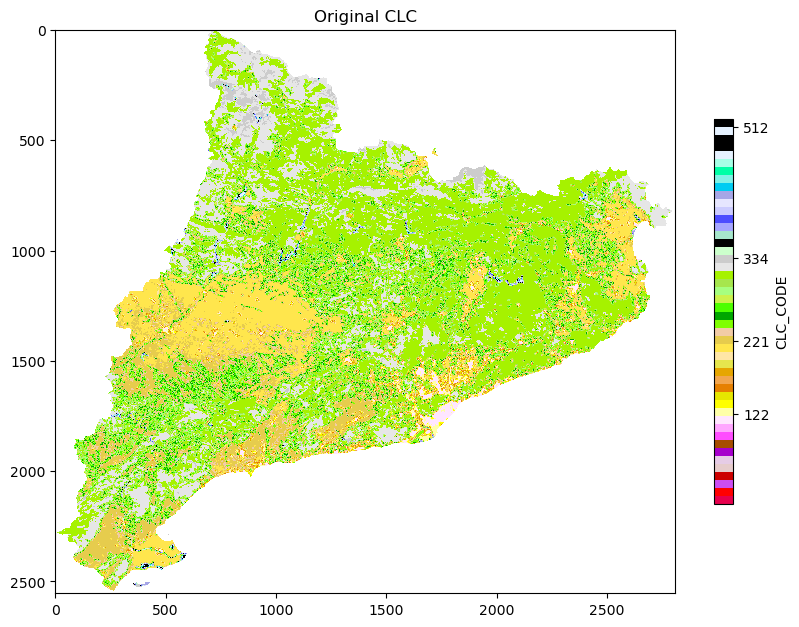

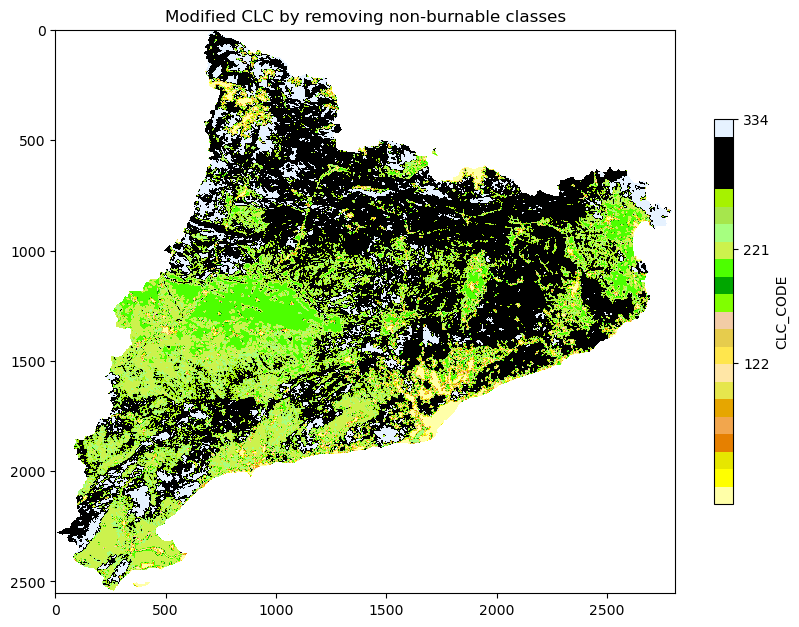

In [22]:
list_of_non_burnable_clc = [
    111, 112, 121, 122, 123, 124, 131, 132, 133, 141, 142,
    331, 332, 333, 335,
    411, 412, 421, 422, 423,
    511, 512, 521, 522, 523
]

# Below, some considerations in the 3XX classes of the CLC and their degree of burnability.
# 331 332 333  are respectively beaches, dunes, sands; bare rocks; sparsely vegetated areas; in this case I will consider them as non-burnable
# 334 burnt areas in this case I will consider them as burnable
# 335 glaciers and perpetual snow in this case I will consider them as non-burnable

# Creating legends for newclc
burnables = set(clc_leg['CLC_CODE'].tolist()) - set(list_of_non_burnable_clc)
burnables = list(burnables)
cmap2_gdf = clc_leg.loc[:,['CLC_CODE','R', 'G', 'B']]
cmap2_gdf = cmap2_gdf[cmap2_gdf['CLC_CODE'].isin(burnables)]
cmap2 = mcolors.ListedColormap(cmap2_gdf[['R', 'G', 'B']].values/255.0, N=cmap2_gdf['CLC_CODE'].nunique()-1)

# Open the raster
with rasterio.open(clc_path_clip) as src:
    # Read the raster band
    band = src.read(1)
    # First plot, left side of the multiplot
    fig, ax = plt.subplots(figsize=(10, 10))
    # Plot the raster
    plt.imshow(np.where(ref == -9999, np.nan, band), cmap = cmap)
    plt.title('Original CLC')
    plt.colorbar(shrink = 0.5, label = 'CLC_CODE', ticks = [122, 221, 334, 512])
    plt.show()
    # Set the values in list_of_non_burnable_clc to 0
    band[np.isin(band, list_of_non_burnable_clc)] = 0
    # Plot the raster, right side of the multiplot
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(np.where(ref == -9999, np.nan, band), cmap = cmap2)
    plt.title('Modified CLC by removing non-burnable classes')
    plt.colorbar(shrink = 0.5, label = 'CLC_CODE', ticks = [122, 221, 334, 512])
    plt.show()
    # Save the modified raster
    with rasterio.open(clc_path_clip_nb, 'w', **src.profile) as dst:
        dst.write(band, 1)

## Fire Data

### Cleaning

Data cleaning of Catalan wildfires. Discard all rows whose `"YEAR_FIRE"` is not of 4 characters. How many are the rows discarded? The row discarded seem to be the overlapping fires... for this they have multiple date entries.

In [23]:
fires = gpd.read_file(fires_path_shapes)
print("Number of rows...", len(fires))

rows_discarded = len(fires) - len(fires[fires['YEAR_FIRE'].str.len() == 4])
fires_2 = fires[fires['YEAR_FIRE'].str.len() == 4]
fires_0 = fires[fires['YEAR_FIRE'].str.len() != 4]
print("Number of rows discarded:", rows_discarded)
print("These are the buggy entries in the FIRE_YEAR column...",fires_0.YEAR_FIRE.unique())
print("......")
print("I will convert to int the YEAR_FIRE column of the non buggy data...")

#fires_2.loc['YEAR_FIRE'] = fires_2['YEAR_FIRE'].astype(int)
fires_2.loc[:, 'YEAR_FIRE'] = fires_2['YEAR_FIRE'].astype(int) # to avoid setting with copy warning
print("The filtered dataset comprises of ", len(fires_2), "rows, spanning the years" , fires_2.YEAR_FIRE.min(), "to", fires_2.YEAR_FIRE.max())

# in the following, fires_2 will be our geo dataframe with the fires.
# Now selecting just the fires_2 with year > 1990
fires_2 = fires_2[fires_2['YEAR_FIRE'] > 1990]
print("After the filtering the final filtered dataset comprises of ", len(fires_2), "rows, spanning the years" , fires_2.YEAR_FIRE.min(), "to", fires_2.YEAR_FIRE.max())

Number of rows... 1217
Number of rows discarded: 395
These are the buggy entries in the FIRE_YEAR column... ['Unknown' '1995 - 2015 - 2012' '1995 - 2015 - 2021' '1995 - 2012 - 2021'
 '1995 - 2006 - 2010' '1995 - 1999 - 2002' '1995 - 2000 - 2021'
 '1986 - 1995 - 2019' '1986 - 1998 - 2004' '1988 - 1993 - 2001'
 '1986 - 2011' '1986 - 2012' '1986 - 1997' '1986 - 1995' '1998 - 2020'
 '1986 - 1999 - 2012' '1986 - 2003 - 2012' '1986 - 2004 - 2012'
 '1986 - 2006 - 2012' '1986 - 2007 - 2012' '1989 - 1994' '1989 - 2003'
 '1989 - 2005' '1989 - 2020' '1989 - 2014' '1989 -2012' '1990 - 1994'
 '1995 - 2010' '1995 - 2017' '1986 - 2000 - 2021' '1986 - 2001 - 2003'
 '1986 - 2001 - 2022' '1986 - 2002 - 2022' '1988 - 2001' '1988 - 2003'
 '1988 - 2009' '1988 - 2012' '1988 - 1991' '1988 - 1994' '1988 - 2007'
 '1986 - 2016' '1986 - 2022' '1986 - 1994' '1986 - 2005' '1994 - 2003'
 '1994 - 2011' '1994 - 1987' '1990 - 2016' '1990 - 2020' '2005 - 2020'
 '2005 - 2013' '2006 - 2012' '1986 - 2004 - 2022' '1986 - 1

To avoid overfitting I am going to delete two big fires from the data set. They are located in the central part of Catalonia and they did not represent the classical fire regime in the region.
198969,0
199033,0

In [24]:
fires_2 = fires_2.loc[(fires_2['OBJECTID'] != 199033.0) & (fires_2['OBJECTID'] != 198969.0),:]

The geodataframe of the fires is rasterized and saved to file(raster), using the corine land cover raster as a reference.

In [25]:
# Rasterize the fires...
fires_rasterized = shared_funcs.rasterize_numerical_feature(fires_2, clc_path_clip, column=None)
# save to file
shared_funcs.save_raster_as(fires_rasterized, fires_path_raster, clc_path_clip)

Shape of the reference raster: (2554, 2810)
Transform of the reference raster: | 100.00, 0.00, 3488731.36|
| 0.00,-100.00, 2241986.65|
| 0.00, 0.00, 1.00|
Features.rasterize is launched...
Features.rasterize is done...


### Visualization

Check that the rasterized fires can assume just the values 0 and 1 and there are no nan values.

The values of fire rasterised file are:  [0. 1.]
There is a NaN in file:  False


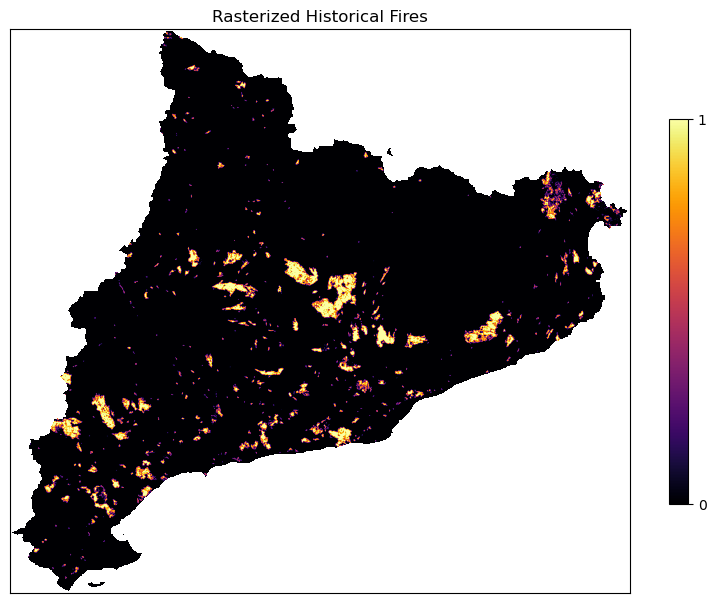

In [26]:
# Values of the rasterized fires
print('The values of fire rasterised file are: ', np.unique(fires_rasterized))

# Does the rasterized files have nan?
print('There is a NaN in file: ', np.isnan(fires_rasterized).any())

# Visualize the rasterized fires
fig, ax = plt.subplots(figsize=(10, 10))
cx = ax.imshow(np.where(ref == -9999, np.nan, fires_rasterized), cmap = 'inferno')
fig.colorbar(cx, ax=ax, shrink=0.5, ticks=[0, 1])
ax.set_title('Rasterized Historical Fires')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

## Creating our model

### Preparation

The `MyRaster` class is defined in `shared_funcs.py` to handle the path and metadata of a raster.
Additional functions assemble the dictionaries with the rasters to be used in the model.

In [27]:
def assemble_climate_dict(clim_category, clim_cat_namefile, clim_var_names):
    """
    Collect climate data from prepared ECLIPS2.0 files.

    Parameters
    ----------
    clim_category : string that can have the following values: "rcp45_2011_2020", "rcp45_2021_2040", "hist_1961_1990", "hist_1991_2010"
    clim_cat_namefile: string which classifies the filenames of the category (tipically the years)
        examples are: "201120", "202140", "196190", "199110"
    clim_var_names: a list of strings with the names of the climate variables to be used in the model. An example of such list is:
    ["MWMT", "TD", "AHM", "SHM", "DDbelow0", "DDabove18", "MAT", "MAP", "Tave_sm", "Tmax_sm", "PPT_at", "PPT_sm", "PPT_sp", "PPT_wt"]
    
    Returns
    -------
    Dictionary with the climate variables as keys and the MyRaster objects as values.
    
    Usage
    -----
    climate_dict = assemble_climate_dict("hist_1991_2010", "1991_2010", clim_var_names)
    future_climate_dict = assemble_climate_dict("rcp45_2021_2040", "202140", clim_var_names)
    """

    climate_paths = []
    for clim_var_name in clim_var_names:
        climate_paths.append(os.path.join(clim_category, clim_var_name + "_" + clim_cat_namefile + ".tif"))

    climate_dict = {}
    for path, label in zip(climate_paths, clim_var_names):
        climate_dict[label] = shared_funcs.MyRaster(path, label)
        climate_dict[label].read_raster()
    return climate_dict


def get_results(model, X_all, full_shape, mask):
    """Get the results of the model and returns a raster with the results
    
    Input:
    model: the model to fit
    X_all: the dataset with the descriptive features
    dem_arr: the dem array data
    mask: the mask of the dem array with all the valid and burnable pixels
    
    example usage:
    Y_raster = get_results( model, X_all,dem_arr, mask)
    """
    # prediction over all the points
    Y_out = model.predict_proba(X_all)
    # array of predictions over the valid pixels
    Y_raster = np.zeros(full_shape)
    Y_raster[mask] = Y_out[:,1]
    # clip susc where dem exsits
    Y_raster[~mask] = -1
    return Y_raster

### Training the model

In [28]:
def make_model(res_path, period, verbose=False):
    # Climate model input fields
    climate_dict = assemble_climate_dict(res_path, period, var_names)
    # DEM input fields
    dem_dict = shared_funcs.assemble_dem_dict(
        [dem_path_clip, dem_path_slope, dem_path_aspect, dem_path_easting, dem_path_northing, dem_path_roughness],
        ["dem", "slope", "aspect", "easting", "northing", "roughness"]
    )
    # Vegetation input fields
    veg_dict, mask = shared_funcs.assemble_veg_dictionary(clc_path_clip_nb, dem_path_clip, verbose=verbose)
    # Fire data
    fires_raster = shared_funcs.MyRaster(fires_path_raster, "fires")
    # Preprocess and assemble training dataset
    X_all, Y_all, columns = shared_funcs.preprocessing(dem_dict, veg_dict, climate_dict, fires_raster, mask, verbose=verbose)
    # Prepare for model training
    model, X_train, X_test, y_train, y_test = shared_funcs.prepare_sample(X_all, Y_all, percentage=0.1, max_depth=10, number_of_trees=100)
    # Train the model
    shared_funcs.fit_and_print_stats(model, X_train, y_train, X_test, y_test, columns)
    # Return the trained model
    return model

In [29]:
model = make_model(clim_path_hist, hist_period, verbose=False)

processing vegetation density: 100%|██████████| 18/18 [00:10<00:00,  1.72it/s]
processing columns: 39it [00:02, 13.25it/s]


Number of burned points: 152232
 I am random sampling the dataset 
reducted df points: 15223 of 152232
X_absence.shape[0] 7024508
X_presence.shape[0] 15223
Running RF on data sample: (20398, 39)
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 10

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    1.9s


building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s


AUC score on test: 0.97
MSE: 0.07
accuracy: 0.90
I am evaluating features importance
importances
roughness : 0.13
perc : 0.09
slope : 0.09
easting : 0.08
northing : 0.07
dem : 0.07
AHM : 0.06
aspect : 0.06
veg : 0.05
DDabove18 : 0.04
SHM : 0.03
MWMT : 0.03
Tmax_sm : 0.02
PPT_sm : 0.02
Tave_sm : 0.02
PPT_sp : 0.02
MAP : 0.02
PPT_wt : 0.02
DDbelow0 : 0.02
TD : 0.02
MAT : 0.01
PPT_at : 0.01


## Historical climate

### Running the model for the historical climate

Apply the model to the historical (training) data and compute susceptibility.

In [30]:
def run_model(model, res_path, period, verbose=False):
    # Climate model input fields
    climate_dict = assemble_climate_dict(res_path, period, var_names)
    # DEM input fields (same as training)
    dem_dict = shared_funcs.assemble_dem_dict(
        [dem_path_clip, dem_path_slope, dem_path_aspect, dem_path_easting, dem_path_northing, dem_path_roughness],
        ["dem", "slope", "aspect", "easting", "northing", "roughness"]
    )
    # Vegetation input fields (same as training)
    veg_dict, mask = shared_funcs.assemble_veg_dictionary(clc_path_clip_nb, dem_path_clip, verbose=verbose)
    # Fire data not needed for running the model, but define output shape
    fires_raster = shared_funcs.MyRaster(fires_path_raster, "fires")
    # Preprocess and assemble input data for the ML model
    X_all, _, _ = shared_funcs.preprocessing(dem_dict, veg_dict, climate_dict, fires_raster, mask, verbose=verbose)
    # Evaluate the model and return results
    return get_results(model, X_all, fires_raster.data.shape, mask)

In [31]:
Y_raster = run_model(model, clim_path_hist, hist_period)

processing vegetation density: 100%|██████████| 18/18 [00:11<00:00,  1.63it/s]
processing columns: 39it [00:03, 10.60it/s]
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    9.2s


Convert results array to a raster and save to a file:

In [32]:
suscep_path_hist = suscep_path / f"suscep_HIST_{hist_period}.tif"

shared_funcs.save_raster_as(Y_raster, suscep_path_hist, dem_path_clip)

I want to extract the 50, 75, 90, 95 quantiles of `Y_raster[Y_raster>=0.0]`. Since the susceptibility is the output of a random forest classifier with `proba = True`, its outputs are distributed between 0 and 1. I need to extract the quantiles of the positive values only, in order to get meaningful data from the arbitrary decisions of the classifier.

In [33]:
print(
    'Min susc is: ', Y_raster[Y_raster>=0.0].min(), '\n'
    'Max susc is: ', Y_raster[Y_raster>=0.0].max(), '\n'
    'Mean susc is: ', Y_raster[Y_raster>=0.0].mean(), '\n'
    'Standard deviation is:', Y_raster[Y_raster>=0.0].std(), '\n\n'
    'q1:', np.quantile(Y_raster[Y_raster>=0.0], 0.5), '\n'
    'q2:', np.quantile(Y_raster[Y_raster>=0.0], 0.75), '\n'
    'q3:', np.quantile(Y_raster[Y_raster>=0.0], 0.9), '\n'
    'q4:', np.quantile(Y_raster[Y_raster>=0.0], 0.95)
)

Min susc is:  0.0 
Max susc is:  0.9979266542956706 
Mean susc is:  0.18200027758841059 
Standard deviation is: 0.2802411677737651 

q1: 0.000689655172413793 
q2: 0.3039389496280068 
q3: 0.6651304890558198 
q4: 0.8084540651023499


### Visualizing the historical susceptibility

Plot the susceptibility for the present climate:

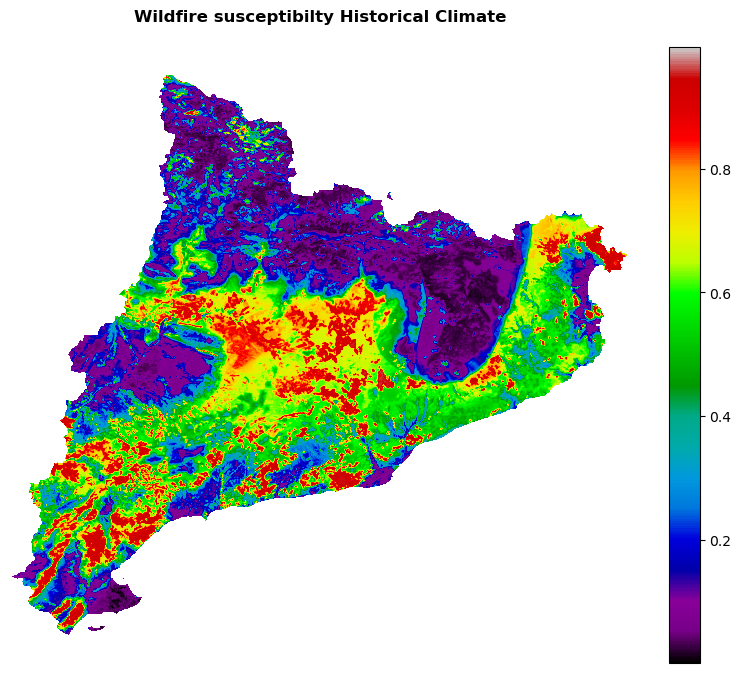

In [34]:
with rasterio.open(suscep_path_hist) as src:
    band = src.read(1)
    shared_funcs.plot_raster_V2(band, ref, cmap='nipy_spectral', title="Wildfire susceptibilty Historical Climate", dpi=100)

## Future climate data

The authors of the ECLIPS2.0 dataset (Chakraborty et al., 2021) used five daily bias-corrected regional climate model results out of nine projections available in the EURO-CORDEX database at the time of this study.
The criteria used to select the five climate projections were as follows:

1. representation of all available RCMs and GCMs;
2. two RCMs being nested in the same driving GCM; and
3. one RCM being driven by two different GCMs.

Such criteria were adopted to ensure the representativeness of all combinations of RCMs and GCMs available in the EURO-CORDEX database.
The models were driven by two Representative Concentration Pathways scenarios RCP4.5 and RCP8.5 (Moss et al., 2010).
The simulations were run for the EUR-11 domain with 0.11° × 0.11° horizontal resolution (Giorgi et al., 2009; Jacob et al., 2014). 

### Future scenario and period and climate model selection

Choose:

1.  A representative concentration pathway scenario from the ECLIPS-2.0 dataset (`future_scenario`).

    - `RCP45`: RCP 4.5
    - `RCP85`: RCP 8.5

2.  A time period to run the machine learning model for (`future_period`).

    - `201120`: 2011 to 2020
    - `202140`: 2021 to 2040
    - `204160`: 2041 to 2060
    - `206180`: 2061 to 2080
  
3.  A climate model data source (`climate_model`).
    The regional climate model (RCM) is nested in the driving global climate model (GCM).

    - `CLMcom_CCLM`:
        - Climate Limited-Area Modelling Community
        - RCM: CLMcom-CLM4-8-17
        - GCM: CNRM-CERFACS-CNRM-CM5
    - `CLMcom_CLM`:
        - Climate Limited-Area Modelling Community
        - RCM: CLMcom-CLM4-8-17
        - GCM: MPI-M-MPI-ESM-LR
    - `DMI_HIRAM`:
        - Danish Meteorological Institute
        - RCM: DMI-HIRHAM5
        - GCM: ICHEC-EC-EARTH
    - `KNMI_RAMCO`:
        - Royal Netherlands Meteorological Institute
        - RCM: KNMI- RACMO22E
        - GCM: MOHC-HadGEM2-ES
    - `MPI_CSC_REMO2009`:
        - Max Planck Institute for Meteorology
        - RCM: MPI-CSC-REMO2009
        - GCM: MPI-M-MPI-ESM-LR

:::{tip}
You can return to this point of the workflow and rerun the following cells for different combinations of RCP scenario, climate model and time period without having to train the machine learning model again (as long as you don't restart the Jupyter kernel).
:::

In [35]:
future_scenario = "RCP45"
future_period = "202140"
climate_model = "CLMcom_CCLM"

In [36]:
# Create a unique identifier from the selected combination for filenames
future_config_id = f"{future_scenario}_{climate_model}_{future_period}"

# Path to data for selected scenario and model in ECLIPS dataset
model_path = ECLIPS2p0_path / f"ECLIPS2.0_{future_scenario}" / f"{climate_model}_{future_scenario[3:-1]}.{future_scenario[-1]}"
# Filenames for selected future period
eclips_files_future = [model_path / f"{vv}_{future_period}.tif" for vv in var_names]

# Output path for resized raster files
clim_path_future = clim_path / future_config_id

:::{note}
When working with the already resized Catalonia ECLIPS2.0 sample data, only scenario `RCP45`, model `CLMcom_CCLM` and periods `201120` or `202140` can be selected.
You can skip the next two steps where climate model data is downloaded from the ECLIPS2.0 mirror and resized.
:::

### Climate model data for chosen configuration

Download the input fields for the machine learning model for the specified configuration of scenario, climate model and future period from the [CLIMAAX ECLIPS2.0 dataset mirror](https://handbook.climaax.eu/resources/datasets/eclips2.0_mirror.html) with pooch (skip if you have downloaded the full ECLIPS dataset or are using the Catalonia sample data).

In [37]:
for file in eclips_files_future:
    file_rel = file.relative_to(eclips_mirror_pooch.path)
    eclips_mirror_pooch.fetch(str(file_rel))

### Resize climate model data

Extract the selected region and reproject the input data (skip if using the Catalonia sample data).

In [38]:
clim_files_future = resize_rasters_gdalwarp(eclips_files_future, clim_path_future)
check_resized_rasters(clim_files_future, dem_path_clip)

100%|██████████| 14/14 [00:00<00:00, 286.67it/s]

### Run the model on future data

To project the model in the future, we need to repeat the same steps as above, but with the future climate data.
The DEM will be the same, and vegetation will be the same (in that case, it is a simplification, but it is ok for now).

In [39]:
Y_raster_future = run_model(model, clim_path_future, future_period)

processing vegetation density: 100%|██████████| 18/18 [00:10<00:00,  1.73it/s]
processing columns: 39it [00:02, 13.53it/s]
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    7.1s


### Visualizing the future susceptibility

Write the susceptibilty for the future climate:

In [40]:
suscep_path_future = suscep_path / f"suscep_{future_config_id}.tif"

shared_funcs.save_raster_as(Y_raster_future, suscep_path_future, dem_path_clip)

Visualization of future susceptibility:

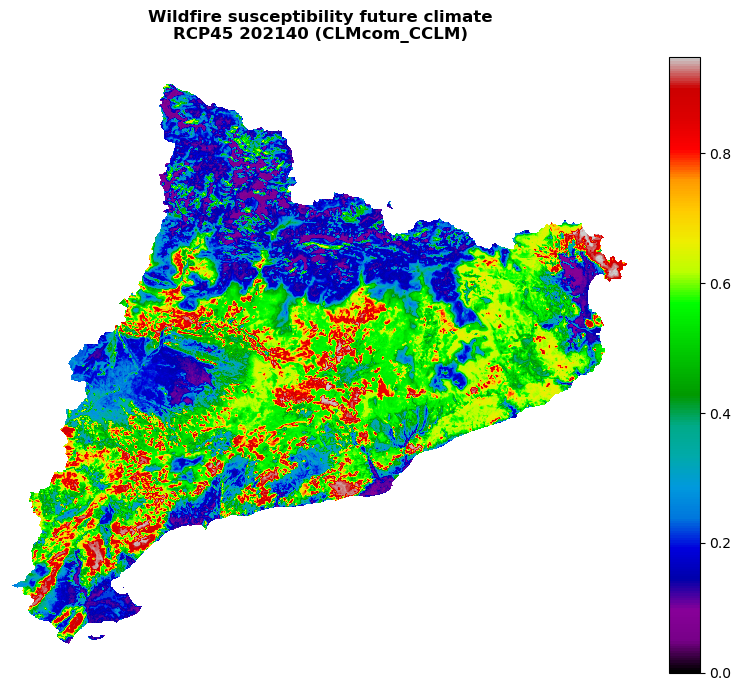

In [41]:
with rasterio.open(suscep_path_future) as src:
    band = src.read(1)
    shared_funcs.plot_raster_V2(
        band,
        ref,
        cmap='nipy_spectral',
        title=(
            "Wildfire susceptibility future climate\n"
            f"{future_scenario} {future_period} ({climate_model})"
        ),
        dpi=100
    )

## Hazard

Functions to define the hazard have been imported from `shared_funcs.py`.

Create the intensity matrix by converting the CLC raster:

In [43]:
my_clc_raster = shared_funcs.MyRaster(clc_path_clip_nb, "clc")

converter = pd.read_excel("./CORINE_to_FuelType.xlsx")
converter_dict = dict(zip(converter.veg.values, converter.aggr.values))

# I obtain the array of the fuel types converting the corine land cover raster
converted_band = shared_funcs.corine_to_fuel_type(my_clc_raster.data.data, converter_dict)

# dtype of the converted band
print('data type is: ', converted_band.dtype)
print('values of original map (here corine) are:','\n', np.unique(converter_dict.keys()))
print('Values of fuel map are:','\n', converter_dict.values())

data type is:  int64
values of original map (here corine) are: 
 [dict_keys([111, 112, 121, 122, 123, 124, 131, 132, 133, 141, 142, 211, 212, 213, 221, 222, 223, 224, 231, 241, 242, 243, 244, 311, 312, 313, 321, 322, 323, 324, 331, 332, 333, 334, 335, 411, 412, 421, 422, 423, 511, 512, 521, 522, 523, 999])]
Values of fuel map are: 
 dict_values([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 2, 4, 4, 1, 3, 3, 3, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


Obtain the hazard map for present climate crossing the susceptibility map with the intensity map:

In [44]:
hazard_path_hist = hazard_path / f"hazard_{hist_config_id}.tif"
hazard_path_future = hazard_path / f"hazard_{future_config_id}.tif"

In [45]:
# compute quantiles for Y_raster
quantiles = np.quantile(Y_raster[Y_raster>=0.0], [0.5, 0.75 ])
print('quantiles are: ', quantiles)

# compute discrete susc array
susc_arr = susc_classes(Y_raster, quantiles) + 1 # >>>>>>>>>> I add 1 to avoid 0 values
print("Now I have just the susc classes", np.unique(susc_arr))

matrix_values = np.array([[1, 2, 3, 4],
                          [2, 3, 4, 5],
                          [3, 3, 5, 6]])

# Compute discrete hazard
hazard_arr = shared_funcs.contigency_matrix_on_array(susc_arr, converted_band, matrix_values, 0 ,-1)

# Future
Y_raster_future = shared_funcs.MyRaster(suscep_path_future, "susc_202140").data
# Compute susceptibility discrete array for future
susc_arr_future = shared_funcs.susc_classes(Y_raster_future, quantiles) + 1 # I add 1 to avoid 0 values
# Compute hazard discrete array for future
hazard_arr_future = shared_funcs.contigency_matrix_on_array(susc_arr_future, converted_band, matrix_values, 0, -1)

# Save the hazard arrays to file (raster)
shared_funcs.save_raster_as_h(hazard_arr, hazard_path_hist, clc_path_clip_nb)
shared_funcs.save_raster_as_h(hazard_arr_future, hazard_path_future, clc_path_clip_nb)

quantiles are:  [0.00068966 0.30393895]
Now I have just the susc classes [1 2 3]


Visualize the future and historical hazard classes:

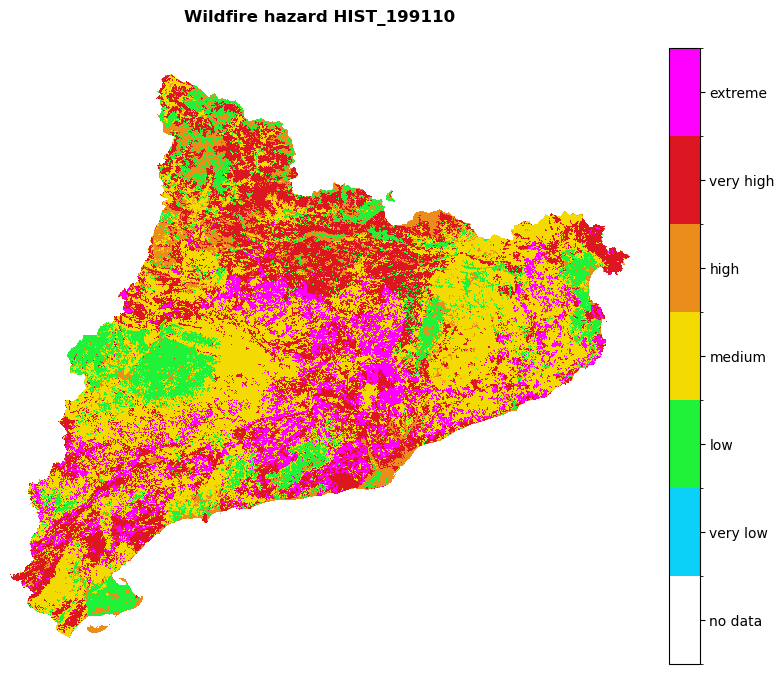

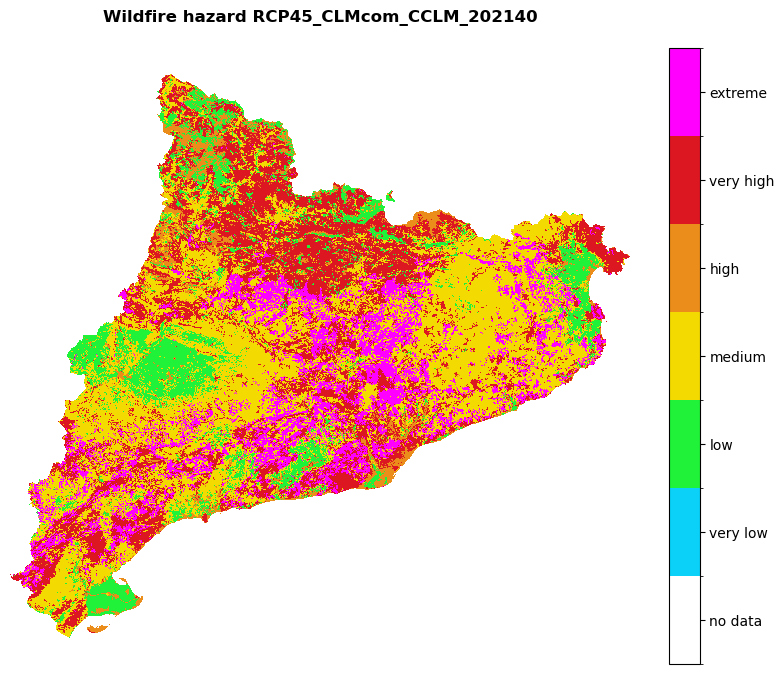

In [46]:
# Hazard cmap
values = [0, 0.9, 1.1, 2.1, 3.1, 4.1, 5.1, 6.1]
colors_ = ['#00000000', '#0bd1f8', '#1ff238', '#f3db02', '#ea8d1b', '#dc1721', '#ff00ff']

# Create colormap
cmap = mcolors.ListedColormap(colors_, N=len(values))
#norm = mcolors.BoundaryNorm(values, len(values))

region_borders.to_crs(epsg=3035, inplace=True)

# Loop over hazard paths and plot
for hazard_path in [hazard_path_hist, hazard_path_future]:
    haz_arr = rasterio.open(hazard_path).read(1)
    name = os.path.basename(hazard_path).split('hazard_')[-1].split('.tif')[0]
    shared_funcs.plot_raster_V2(
        haz_arr,
        ref,
        array_classes=values,
        classes_colors=colors_,
        classes_names=['no data', 'very low', 'low', 'medium', 'high', 'very high', 'extreme'],
        title=f'Wildfire hazard {name}',
        dpi=100
    )

## Contributors

- Andrea Trucchia (Andrea.trucchia@cimafoundation.org)
- Farzad Ghasemiazma (Farzad.ghasemiazma@cimafoundation.org)
- Giorgio Meschi (Giorgio.meschi@cimafoundation.org)


## References

- Tonini, M.; D’Andrea, M.; Biondi, G.; Degli Esposti, S.; Trucchia, A.; Fiorucci, P. (2020): A Machine Learning-Based Approach for Wildfire Susceptibility Mapping. The Case Study of the Liguria Region in Italy. Geosciences 2020, 10, 105. DOI: [10.3390/geosciences10030105](https://doi.org/10.3390/geosciences10030105)

- Trucchia, A.; Meschi, G.; Fiorucci, P.; Gollini, A.; Negro, D. (2022): Defining Wildfire Susceptibility Maps in Italy for Understanding Seasonal Wildfire Regimes at the National Level. Fire 2022, 5, 30. DOI: [10.1071/WF22138](https://doi.org/10.3390/fire5010030)

- Trucchia, A.; Meschi, G.; Fiorucci, P.; Provenzale, A.; Tonini, M.; Pernice, U. (2023): Wildfire hazard mapping in the eastern Mediterranean landscape. International Journal of Wildland Fire 2023, 32, 417-434. DOI: [10.1071/WF22138](https://doi.org/10.1071/WF22138)

- Chakraborty, D.; Dobor, L.; Zolles, A.;, Hlásny, T.; Schueler, S. (2021): High-resolution gridded climate data for Europe based on bias-corrected EURO-CORDEX: The ECLIPS dataset.
 *Geoscience Data Journal*, 2021;8:121–131. DOI: [10.1002/gdj3.110](https://doi.org/10.1002/gdj3.110)

- Chakraborty D.; Dobor L.; Zolles A.; Hlásny T.; Schueler S. (2020): High-resolution gridded climate data for Europe based on bias-corrected EURO-CORDEX: the ECLIPS-2.0 dataset. Zenodo. DOI: [10.5281/zenodo.3952159](https://doi.org/10.5281/zenodo.3952159)